# 2b) Analyse sensitivity of features with respect to parameters

Using the generated random parameters and features, this notebook performs a sensitivity analysis of the features with respect to the parameters.

The pair-wise distance is computed between each random parameter pairn $(p_i, p_j)$ set as:

\begin{equation*}
D_p(i, j)   = cos^{-1}\frac{p_i \cdot p_j}{|p_i||p_j|}
\end{equation*}

Similarly, the distance between each resulting feature pair $(f_i, f_j)$ is:

\begin{equation*}
D_f(i, j)   = cos^{-1}\frac{f_i \cdot f_j}{|f_i||f_j|}
\end{equation*}

After computing the distances we can check how distance in parameter and feature spaces are related, and which set of features yields a higher distance (which should be easier to fit).

In [1]:
%load_ext autoreload
%autoreload

import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import matplotlib.pyplot as plt
import MEAutility as mu
import json
import numpy
import time
import numpy as np
import pandas as pd
import LFPy
from pathlib import Path
from scipy.stats import linregress

%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
random_params_file = 'config/params/random.csv'
random_params = pd.read_csv(random_params_file, index_col='index')

### Compute distance in parameter space

<IPython.core.display.Javascript object>


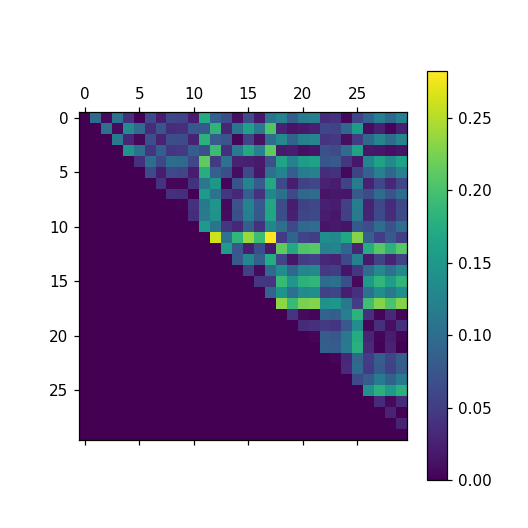

0.0008784523418901885
0.2818401613112614


In [3]:
dist_params_mat = np.zeros((len(random_params), len(random_params)))
for i in np.arange(len(random_params)):
    for j in np.arange(i+1, len(random_params)):
        p1 = random_params.iloc[i].values
        p2 = random_params.iloc[j].values
        cost = np.dot(p1, p2) / (np.linalg.norm(p1) * np.linalg.norm(p2))
        if cost > 0.99999999:
            cost = 1
        dist_params_mat[i, j] =  np.arccos(cost)
dist_params_array = dist_params_mat[dist_params_mat>0].ravel()

plt.matshow(dist_params_mat)
plt.colorbar()

print(np.min(dist_params_array))
print(np.max(dist_params_array))

### Load features

In [4]:
# first we load the probe to get the number of files
probe_file = Path('config/features/random_0/probe.json')

with probe_file.open('r') as f:
    probe_info = json.load(f)

probe = mu.return_mea(info=probe_info)
num_channels = probe.number_electrodes

In [5]:
features_soma = {}
features_bap = {}
features_extra = {}

feature_list_file = Path('config/features_list.json')

with feature_list_file.open('r') as f:
    feature_list = json.load(f)

for feat_set, features in feature_list.items():
    for prot, prot_values in features.items():
        for loc, feat_list in prot_values.items():
            for feat in feat_list:
                key_name = f'{prot}.{loc}.{feat}'
                if feat_set == 'soma':
                    features_soma[key_name] = np.array([np.nan]*len(random_params))
                elif feat_set == 'bap':
                    features_bap[key_name] = np.array([np.nan]*len(random_params))
                elif feat_set == 'extra':
                    if 'MEA' in key_name:
                        for ch in np.arange(num_channels):
                            features_extra[f'{key_name}_{ch}'] = np.array([np.nan]*len(random_params))
                    else:
                        features_extra[key_name] = np.array([np.nan]*len(random_params))

In [6]:
for index in np.arange(len(random_params)):
    feature_folder = f'config/features/random_{index}'
    
    with (Path(feature_folder) / 'soma.json').open('r') as f:
        soma_features = json.load(f)
    with (Path(feature_folder) / 'bap.json').open('r') as f:
        bap_features = json.load(f)
    with (Path(feature_folder) / 'extra.json').open('r') as f:
        extra_features = json.load(f)
    
    for prot, prot_values in soma_features.items():
        for loc, loc_values in prot_values.items():
            for feat, feat_values in loc_values.items():
                key_name = f'{prot}.{loc}.{feat}'
                features_soma[key_name][index] = feat_values[0]
                
    for prot, prot_values in bap_features.items():
        for loc, loc_values in prot_values.items():
            for feat, feat_values in loc_values.items():
                key_name = f'{prot}.{loc}.{feat}'
                features_bap[key_name][index] = feat_values[0]
                
    for prot, prot_values in extra_features.items():
        for loc, loc_values in prot_values.items():
            for feat, feat_values in loc_values.items():
                key_name = f'{prot}.{loc}.{feat}'
                features_extra[key_name][index] = feat_values[0]

In [7]:
df_features_soma = pd.DataFrame.from_dict(features_soma)
df_features_bap = pd.DataFrame.from_dict(features_bap)
df_features_extra = pd.DataFrame.from_dict(features_extra)

Compute and visualize features for **soma**, **bap**, and **extra** sets

<IPython.core.display.Javascript object>


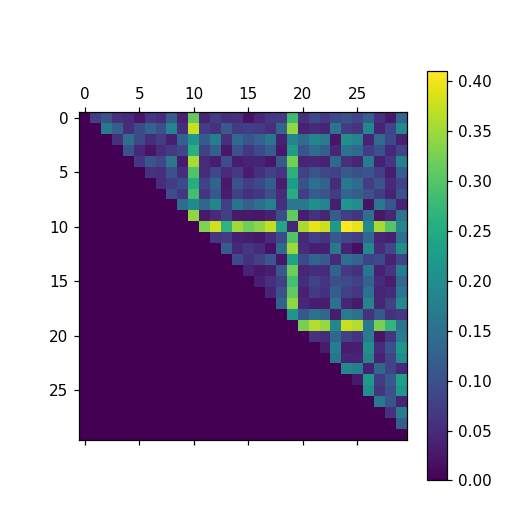

0.017178537205916302
0.40944608448307357


In [8]:
dist_feat_soma_mat = np.zeros((len(random_params), len(random_params)))
for i in np.arange(len(random_params)):
    for j in np.arange(i+1, len(random_params)):
        f1 = df_features_soma.iloc[i].values
        f2 = df_features_soma.iloc[j].values
        cost = np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
        if cost > 0.99999999:
            cost = 1
        dist_feat_soma_mat[i, j] =  np.arccos(cost)
dist_feat_soma_array = dist_feat_soma_mat[dist_feat_soma_mat>0].ravel()

plt.matshow(dist_feat_soma_mat)
plt.colorbar()

print(np.min(dist_feat_soma_array))
print(np.max(dist_feat_soma_array))

<IPython.core.display.Javascript object>


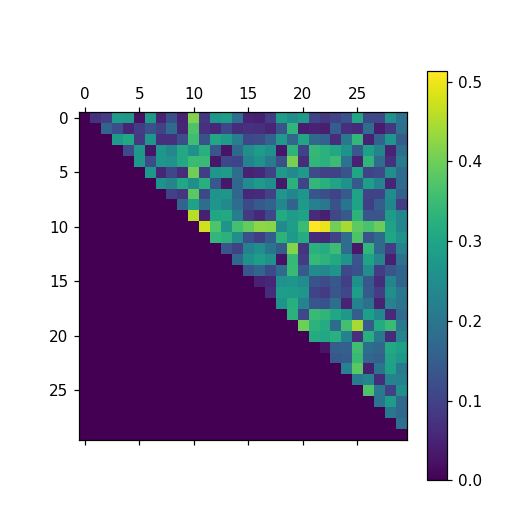

0.023403983429146763
0.5131136492677445


In [9]:
dist_feat_bap_mat = np.zeros((len(random_params), len(random_params)))
for i in np.arange(len(random_params)):
    for j in np.arange(i+1, len(random_params)):
        f1 = df_features_bap.iloc[i].values
        f2 = df_features_bap.iloc[j].values
        
        # only compute distance on finite features
        f1_not_nan = np.where(np.isnan(f1) == False)
        f2_not_nan = np.where(np.isnan(f2) == False)
        
        not_nan = np.intersect1d(f1_not_nan, f2_not_nan)
        f1 = f1[not_nan]
        f2 = f2[not_nan]
        cost = np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
        if cost > 0.99999999:
            cost = 1
        dist_feat_bap_mat[i, j] =  np.arccos(cost)
dist_feat_bap_array = dist_feat_bap_mat[dist_feat_bap_mat>0].ravel()

plt.matshow(dist_feat_bap_mat)
plt.colorbar()

print(np.min(dist_feat_bap_array))
print(np.max(dist_feat_bap_array))

<IPython.core.display.Javascript object>


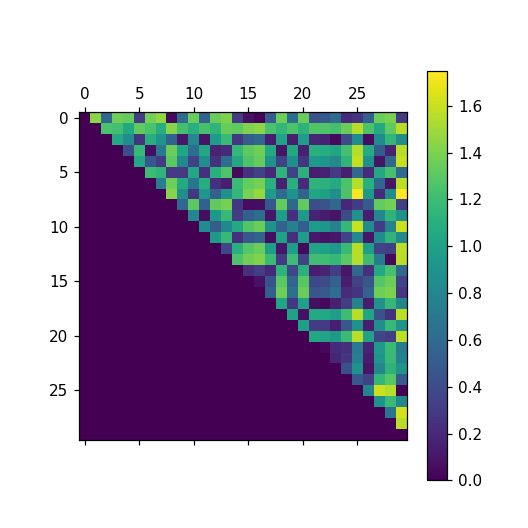

0.01717001260631955
1.7474476389375113


In [10]:
dist_feat_extra_mat = np.zeros((len(random_params), len(random_params)))
for i in np.arange(len(random_params)):
    for j in np.arange(i+1, len(random_params)):
        f1 = df_features_extra.iloc[i].values
        f2 = df_features_extra.iloc[j].values
        
        # only compute distance on finite features
        f1_not_nan = np.where(np.isnan(f1) == False)
        f2_not_nan = np.where(np.isnan(f2) == False)
        
        not_nan = np.intersect1d(f1_not_nan, f2_not_nan)
        f1 = f1[not_nan]
        f2 = f2[not_nan]
        cost = np.dot(f1, f2) / (np.linalg.norm(f1) * np.linalg.norm(f2))
        if cost > 0.99999999:
            cost = 1
        dist_feat_extra_mat[i, j] =  np.arccos(cost)
dist_feat_extra_array = dist_feat_extra_mat[dist_feat_extra_mat>0].ravel()

plt.matshow(dist_feat_extra_mat)
plt.colorbar()

print(np.min(dist_feat_extra_array))
print(np.max(dist_feat_extra_array))

<IPython.core.display.Javascript object>


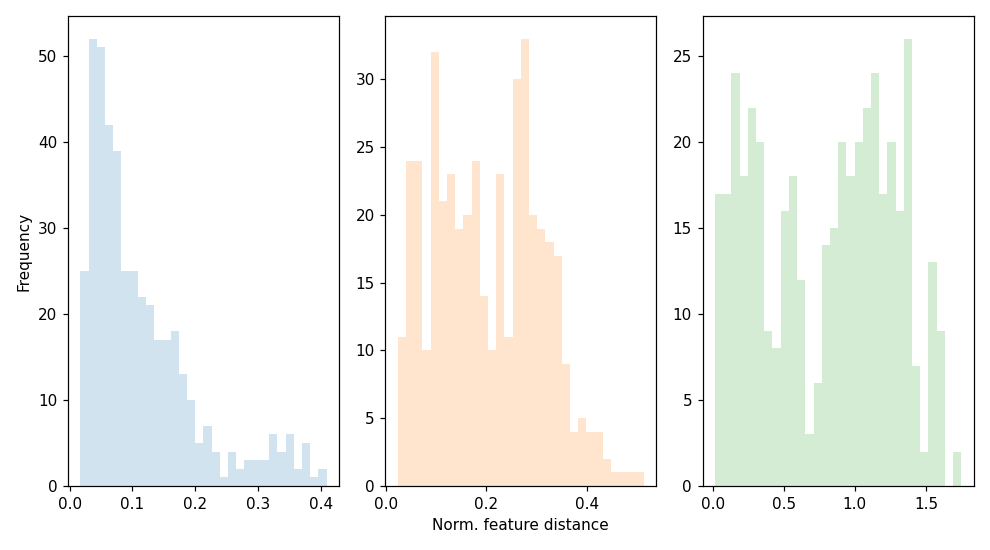

In [11]:
fig1, axs1 = plt.subplots(1, 3)
fig1.set_size_inches(9, 5)
_ = axs1[0].hist(dist_feat_soma_array, bins=30, color='C0', alpha=0.2)
_ = axs1[1].hist(dist_feat_bap_array, bins=30, color='C1', alpha=0.2)
_ = axs1[2].hist(dist_feat_extra_array, bins=30, color='C2', alpha=0.2)
axs1[0].set_ylabel('Frequency')
axs1[1].set_xlabel('Norm. feature distance')
fig1.tight_layout()

<IPython.core.display.Javascript object>


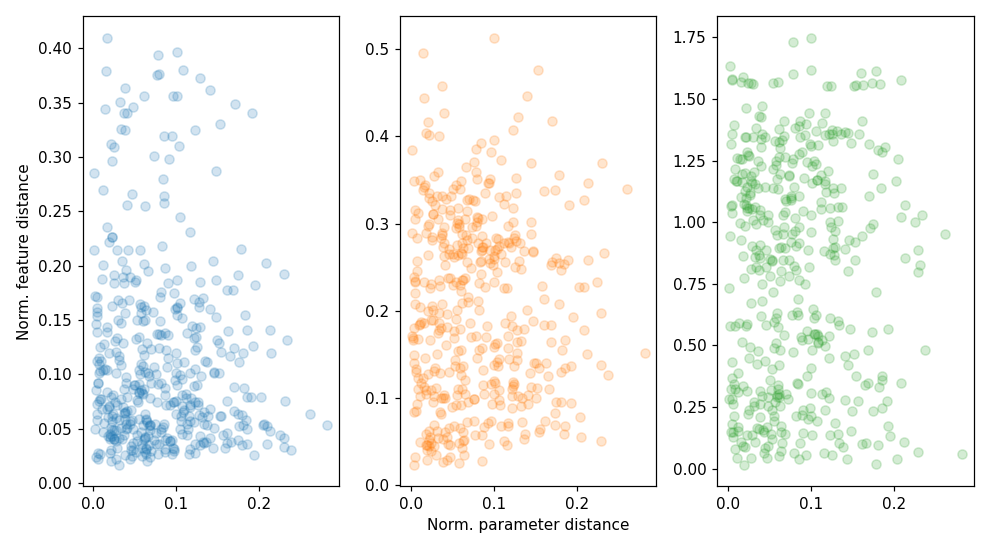

In [12]:
fig2, axs2 = plt.subplots(1, 3)
fig2.set_size_inches(9, 5)
_ = axs2[0].plot(dist_params_array, dist_feat_soma_array, color='C0', marker='o', ls='', alpha=0.2)
_ = axs2[1].plot(dist_params_array, dist_feat_bap_array, color='C1', marker='o', ls='', alpha=0.2)
_ = axs2[2].plot(dist_params_array, dist_feat_extra_array, color='C2', marker='o', ls='', alpha=0.2)
axs2[0].set_ylabel('Norm. feature distance')
axs2[1].set_xlabel('Norm. parameter distance')
fig2.tight_layout()